In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize as normalize_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In this exercise, we investigate the performance of LinUCB. In particular, we want to understand the impact of the representation on the learning process. 

A representation is a mapping $\phi_i : X \times A \to \mathbb{R}^{d_i}$. A representation is **realizable** when $\exists \theta \in \mathbb{R}^{d_i}$ such that $r(x,a) = \phi_i(x,a)^\top \theta$, for all $x,a$.

Note that a linear contextual bandit problem admits multiple realizable representations. The question we want to investigate is:    
*Are all the representations equally good for learning?*

### Environment
We start definining utility functions and the environment we are going to use


In [2]:
#@title Utilities for building linear representations {display-mode: "form"}
def normalize_linrep(features, param, scale=1.):
    param_norm = np.linalg.norm(param)
    new_param = param / param_norm * scale
    new_features = features * param_norm / scale
    return new_features, new_param

def random_transform(features, param, normalize=True, seed=0):
    rng = np.random.RandomState(seed)
    dim = len(param)
    A = rng.normal(size=(dim, dim))

    A = rng.normal(size=(dim, dim))
    q, r = np.linalg.qr(A)
    
    new_features = features @ q
    new_param = q.T @ param
        
    if normalize:
        new_features, new_param = normalize_linrep(new_features, new_param)
    
    val = features @ param - new_features @ new_param
    assert np.allclose(features @ param, new_features @ new_param)
    return new_features, new_param

def make_random_linrep(
    n_contexts, n_actions, feature_dim, 
    ortho=True, normalize=True, seed=0,
    method="gaussian"):

    rng = np.random.RandomState(seed)
    if method == "gaussian":
        features = rng.normal(size=(n_contexts, n_actions, feature_dim))
    elif method == "bernoulli":
        features = rng.binomial(n=1, p=rng.rand(), size=(n_contexts, n_actions, feature_dim))

    param = 2 * rng.uniform(size=feature_dim) - 1
    
    #Orthogonalize features
    if ortho:
        features = np.reshape(features, (n_contexts * n_actions, feature_dim))
        orthogonalizer = PCA(n_components=feature_dim, random_state=seed) #no dimensionality reduction
        features = orthogonalizer.fit_transform(features)
        features = np.reshape(features, (n_contexts, n_actions, feature_dim))
        features = np.take(features, rng.permutation(feature_dim), axis=2)
    
    if normalize:
        features, param = normalize_linrep(features, param)
        
    return features, param

def derank_hls(features, param, newrank=1, transform=True, normalize=True, seed=0):
    nc = features.shape[0]

    rewards = features @ param
    # compute optimal arms
    opt_arms = np.argmax(rewards, axis=1)
    # compute features of optimal arms
    opt_feats = features[np.arange(nc), opt_arms, :]
    opt_rews = rewards[np.arange(nc), opt_arms].reshape((nc, 1)) 
    remove = min(max(nc - newrank + 1, 0), nc)
    
    new_features = np.array(features)
    outer = np.matmul(opt_rews[:remove], opt_rews[:remove].T)
    xx = np.matmul(outer, opt_feats[:remove, :]) \
        / np.linalg.norm(opt_rews[:remove])**2
    new_features[np.arange(remove), opt_arms[:remove], :] = xx
    
    new_param = param.copy()
    
    if transform:
        new_features, new_param = random_transform(new_features, new_param, normalize=normalize, seed=seed)
    elif normalize:
        new_features, new_param = normalize_linrep(new_features, new_param, seed=seed)
        
    assert np.allclose(features @ param, new_features @ new_param)
    return new_features, new_param


def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = A_inv @ u
    den = 1 + np.dot(u.T, Au)
    A_inv -= np.outer(Au, Au) / (den)
    return A_inv, den


"""Computes minimum eigenvalue of AA^T"""
def min_eig_outer(A, weak=False):
    EPS = 1e-8
    _, sv, _ = np.linalg.svd(A)
    i = 0
    if weak:
        while abs(sv[len(sv)-1-i])<EPS and i<len(sv):
            i += 1
            
    return sv[len(sv)-1-i]**2

def optimal_arms(rewards):
    return np.argmax(rewards, axis=1)

def optimal_rewards(features, rewards):
    n_contexts = features.shape[0]
    ii = np.arange(n_contexts)
    return rewards[ii, optimal_arms(rewards)]

def optimal_features(features, rewards):
    n_contexts = features.shape[0]
    ii = np.arange(n_contexts)
    return features[ii, optimal_arms(rewards), :]

def hls_rank(features, rewards, tol=None):
    return np.linalg.matrix_rank(optimal_features(features, rewards), tol)

def is_hls(features, rewards, tol=None):
    dim = features.shape[2]
    return hls_rank(features, rewards, tol) == dim

def hls_lambda(features, rewards, cprobs=None, weak=False):
    n_contexts = features.shape[0]
    if cprobs is None:
        mineig = min_eig_outer(optimal_features(features, rewards), weak) / n_contexts
    else:
        assert np.allclose(np.sum(cprobs), 1.)
        mineig = min_eig_outer(np.sqrt(np.array(cprobs)[:, None]) * 
                               optimal_features(features, rewards), weak)
    if np.allclose(mineig, 0.):
        return 0.
    return mineig

In [3]:
class LinearEnv():
    def __init__(self, features, param, rew_noise=0.5, random_state=0) -> None:
        self.features = features
        self.param = param
        self.rewards = features @ param
        self.rew_noise = rew_noise
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)
        self.n_contexts, self.n_actions, self.feat_dim = self.features.shape

    def get_available_actions(self):
        """ Return the actions available at each time
        """
        actions = np.arange(self.n_actions)
        return actions
    
    def sample_context(self):
        """ Return a random context
        """
        self.idx = self.rng.choice(self.n_contexts, 1).item()
        return self.idx

    def step(self, action):
        """ Return a realization of the reward in the context for the selected action
        """
        return self.rewards[self.idx, action] + self.rng.randn() * self.rew_noise

    def best_reward(self):
        """ Maximum reward in the current context
        """
        return self.rewards[self.idx].max()
    
    def expected_reward(self, action):
        return self.rewards[self.idx, action]

class LinearRepresentation():
    """ Returns the features associated to each context and action
    """
    def __init__(self, features) -> None:
        self.features = features
    
    def features_dim(self):
        return self.features.shape[2]
    
    def get_features(self, context, action):
        return self.features[context, action]

In [4]:
SEED = 0
NOISE = 0.5
nc, na, dim = 100, 5, 10
features, param = make_random_linrep(
    n_contexts=nc, n_actions=na, feature_dim=dim, 
    ortho=True, normalize=True, seed=SEED, method="gaussian")

env = LinearEnv(features=features, param=param, rew_noise=NOISE)

# Algorithms

In [5]:
#@title LinUCB {display-mode: "form"}
class LinUCB:
  
    def __init__(self, env, representation, reg_val, noise_std,
        features_bound,
        param_bound, delta=0.01, random_state=0):
        self.env = env
        self.rep = representation
        self.reg_val = reg_val
        self.noise_std = noise_std
        self.features_bound = features_bound
        self.param_bound=param_bound
        self.delta = delta
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

    def run(self, horizon):
        instant_reward = np.zeros(horizon)
        best_reward = np.zeros(horizon)
        
        dim = self.rep.features_dim()
        inv_A = np.eye(dim) / self.reg_val
        b_vec = np.zeros(dim)
        A_logdet = np.log(self.reg_val) * dim
        theta = inv_A @ b_vec
        for t in range(horizon):
            context = env.sample_context()
            avail_actions = env.get_available_actions()
            # compute UCBs
            scores = np.zeros(len(avail_actions))
            val = A_logdet - dim * np.log(self.reg_val) - 2 * np.log(self.delta)
            beta = self.noise_std * np.sqrt(val) + self.param_bound * np.sqrt(self.reg_val)

            for i, a in enumerate(avail_actions):
                v = self.rep.get_features(context, a)
                tie_breaking_noise = self.rng.randn() * 1e-15
                norm_val = v.dot(inv_A.dot(v))
                bonus = beta * np.sqrt(norm_val)
                scores[i] = v.dot(theta) + bonus + tie_breaking_noise
            
            # select and execute action
            action = np.argmax(scores)
            reward = env.step(action)

            # update
            v = self.rep.get_features(context, action)
            b_vec += v * reward
            den = 1. + v.dot(inv_A.dot(v))
            outp = np.outer(v,v)
            inv_A -= inv_A.dot(outp.dot(inv_A)) / den
            A_logdet += np.log(den)
            theta = inv_A @ b_vec

            # regret computation
            instant_reward[t] = self.env.expected_reward(action)
            best_reward[t] = self.env.best_reward()
        
        return {"regret": np.cumsum(best_reward - instant_reward)}


In [6]:
class LEADER:
  
    def __init__(
        self, env, representations, reg_val, noise_std,
        features_bounds,
        param_bounds, delta=0.01, random_state=0,
        check_elim_condition_every=1
      ):
        self.env = env
        self.reps = representations
        self.reg_val = reg_val
        self.noise_std = noise_std
        self.features_bound = features_bounds
        self.param_bound = param_bounds
        self.delta = delta
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)
        self.check_elim_condition_every = check_elim_condition_every

    def run(self, horizon):
        instant_reward = np.zeros(horizon)
        best_reward = np.zeros(horizon)
        M = len(self.reps)

        active_reps = list(range(M))

        # prepare structure for SSE
        SSE_A = np.zeros(M)
        SSE_B = []
        SSE_C = []
        SSE_D = []
        for el in self.reps:
            d = el.features_dim()
            SSE_B.append(np.zeros(d))
            SSE_C.append(np.zeros(d))
            k = int((d * (d-1)) / 2)
            SSE_D.append(np.zeros(k))

        # prepare structure for LinUCB
        inv_A = []
        b_vec = []
        A_logdet = []
        theta = []
        for i in range(M):
            dim = self.reps[i].features_dim()
            inv_A.append(np.eye(dim) / self.reg_val)
            b_vec.append(np.zeros(dim))
            A_logdet.append(np.log(self.reg_val) * dim)
            theta.append(inv_A[i] @ b_vec[i])
        
        for t in range(horizon):
            context = env.sample_context()
            avail_actions = env.get_available_actions()

            # compute UCBs of active representations
            M_active, n_actions = len(active_reps), len(avail_actions)
            scores = np.zeros((M_active, n_actions))
            for j, rep_id in enumerate(active_reps):
              dim = self.reps[j].features_dim()
              val = A_logdet[rep_id] - dim * np.log(self.reg_val) - 2 * np.log(self.delta)
              beta = self.noise_std * np.sqrt(val) + self.param_bound[rep_id] * np.sqrt(self.reg_val)

              for i, a in enumerate(avail_actions):
                  v = self.reps[rep_id].get_features(context, a)
                  tie_breaking_noise = self.rng.randn() * 1e-15
                  norm_val = v.dot(inv_A[rep_id].dot(v))
                  bonus = beta * np.sqrt(norm_val)
                  scores[j, i] = v.dot(theta[rep_id]) + bonus + tie_breaking_noise
            
            # select and execute action
            action = np.argmax(np.min(scores, axis=0))
            reward = env.step(action)

            # update
            # SSE = \sum_i (y_i - x_i w)^2
            #     = \sum_i y_i^2 + (x_i w)^2  - 2y_i x_i w
            #     = \sum_i y_i^2 - 2y_i x_i w
            #       + \sum_i [ \sum_j (x_{ij}^2 w_j^2) + 2 \sum_{k}\sum_{j=k+1} x_{ik} x_{ij} w_{ik} w_{ij} ]
            # Let's
            #     A = \sum_i y_i^2
            #     B = \sum_i -2y_i x_i
            #     C = \sum_i x_{ij}^2  (dim d)
            #     D = \sum_i 2 x_{ik} x_{ij} (dim d*(d-1)/2)
            # Then, for any w
            # SSE = A + Bw + \sum_j C_j w_j \sum_{k}\sum_{j=k+1} D_k D_j w_i w_j
            # MSE = SSE / t
            for i in active_reps:
                v = self.reps[i].get_features(context, action)
                d = len(v)
                b_vec[i] += v * reward
                den = 1. + v.dot(inv_A[i].dot(v))
                outp = np.outer(v,v)
                inv_A[i] -= inv_A[i].dot(outp.dot(inv_A[i])) / den
                A_logdet[i] += np.log(den)
                theta[i] = inv_A[i] @ b_vec[i]
                #update SSE
                SSE_A[i] += reward * reward
                SSE_B[i] = SSE_B[i] - 2 * reward * v
                SSE_C[i] = SSE_C[i] + v**2
                idx = 0
                for k in range(d):
                    for j in range(k+1, d):
                        SSE_D[i][idx] += 2*v[k]*v[j]
                        idx += 1

            # eliminate?
            if t % self.check_elim_condition_every == 0:
                # compute MSEs
                mse = -np.inf*np.ones(M)
                min_mse_plusoffset = np.inf
                for i in active_reps:
                    L = self.features_bound[i]
                    S = self.param_bound[i]
                    d = inv_A[i].shape[0]
                    tt = t+1
                    offset = (24 * np.log(2 * tt) + 8* np.log(M * M / self.delta) + 8 * d * np.log(12 * L * S * tt) + 1) / tt
                    sse = SSE_A[i]
                    idx = 0 
                    for k in range(d):
                        sse += (SSE_B[i][k] + SSE_C[i][k] * theta[i][k]) * theta[i][k]
                        for j in range(k+1,d):
                            sse += SSE_D[i][idx] * theta[i][k] * theta[i][j]
                            idx += 1
                    mse[i] = sse / tt
                    min_mse_plusoffset = min(min_mse_plusoffset, mse[i] + offset)

                # evaluate elimination condition
                new_active_reps = []
                for i in active_reps:
                    if mse[i] <= min_mse_plusoffset:
                        new_active_reps.append(i)
                    else:
                        print(f"t({t}): elim {i} since {mse[i]} > {min_mse_plusoffset}")
                if len(new_active_reps) != len(active_reps):
                    print(f"new active set: {new_active_reps}")
                active_reps = new_active_reps

            # regret computation
            instant_reward[t] = self.env.expected_reward(action)
            best_reward[t] = self.env.best_reward()
        
        return {"regret": np.cumsum(best_reward - instant_reward)}

In [7]:
class LEADERSelect:
  
    def __init__(
        self, env, representations, reg_val, noise_std,
        features_bounds,
        param_bounds, delta=0.01, random_state=0,
        recompute_every=1,
        normalize=True
      ):
        self.env = env
        self.reps = representations
        self.reg_val = reg_val
        self.noise_std = noise_std
        self.features_bound = features_bounds
        self.param_bound = param_bounds
        self.delta = delta
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)
        self.recompute_every = recompute_every
        self.normalize = normalize

    def run(self, horizon):
        instant_reward = np.zeros(horizon)
        best_reward = np.zeros(horizon)
        M = len(self.reps)

        # active_reps = list(range(M))
        self.mineig = []
        self.normalized_rep_scores = []

        # prepare structure for SSE
        SSE_A = np.zeros(M)
        SSE_B = []
        SSE_C = []
        SSE_D = []
        for el in self.reps:
            d = el.features_dim()
            SSE_B.append(np.zeros(d))
            SSE_C.append(np.zeros(d))
            k = int((d * (d-1)) / 2)
            SSE_D.append(np.zeros(k))

        # prepare structure for LinUCB
        inv_A = []
        Amtx = []
        b_vec = []
        A_logdet = []
        theta = []
        for i in range(M):
            dim = self.reps[i].features_dim()
            inv_A.append(np.eye(dim) / self.reg_val)
            Amtx.append(np.zeros((dim, dim)))
            b_vec.append(np.zeros(dim))
            A_logdet.append(np.log(self.reg_val) * dim)
            theta.append(inv_A[i] @ b_vec[i])
        
        for t in range(horizon):
            context = env.sample_context()
            avail_actions = env.get_available_actions()


            # select representation
            if t % self.recompute_every == 0:
                min_eigs = np.zeros(M)
                normalized_rep_scores = np.zeros(M)
                # compute min eigs
                for i in range(M):
                    dm = Amtx[i]
                    eigs, _ = np.linalg.eig(dm)
                    assert np.isclose(np.imag(eigs).max(), 0)
                    min_eigs[i] = np.real(eigs).min()
                    normalized_rep_scores[i] = min_eigs[i] / self.features_bound[i]**2
                
                # compute MSEs
                mse = -np.inf*np.ones(M)
                min_mse_plusoffset = np.inf
                for i in range(M):
                    L = self.features_bound[i]
                    S = self.param_bound[i]
                    d = inv_A[i].shape[0]
                    tt = t+1
                    offset = (24 * np.log(2 * tt) + 8* np.log(M * M / self.delta) + 8 * d * np.log(12 * L * S * tt) + 1) / tt
                    sse = SSE_A[i]
                    idx = 0 
                    for k in range(d):
                        sse += (SSE_B[i][k] + SSE_C[i][k] * theta[i][k]) * theta[i][k]
                        for j in range(k+1,d):
                            sse += SSE_D[i][idx] * theta[i][k] * theta[i][j]
                            idx += 1
                    mse[i] = sse / tt
                    min_mse_plusoffset = min(min_mse_plusoffset, mse[i] + offset)

                self.mineig.append(min_eigs)
                self.normalized_rep_scores.append(normalized_rep_scores)

                cond = mse > min_mse_plusoffset
                # if condition is False, we set the maximum value
                # i.e. the representation will not be selected
                if self.normalize:
                    value = normalized_rep_scores - cond * np.finfo(float).max 
                else:
                    value = min_eigs - cond * np.finfo(float).max 

                winners = np.argwhere(value == value.max()).flatten().tolist()
                selected_rep = self.rng.choice(winners)

            # compute UCBs of selected representation
            n_actions = len(avail_actions)
            scores = np.zeros(n_actions)
            dim = self.reps[selected_rep].features_dim()
            val = A_logdet[selected_rep] - dim * np.log(self.reg_val) - 2 * np.log(self.delta)
            beta = self.noise_std * np.sqrt(val) + self.param_bound[selected_rep] * np.sqrt(self.reg_val)

            for i, a in enumerate(avail_actions):
                v = self.reps[selected_rep].get_features(context, a)
                tie_breaking_noise = self.rng.randn() * 1e-15
                norm_val = v.dot(inv_A[selected_rep].dot(v))
                bonus = beta * np.sqrt(norm_val)
                scores[i] = v.dot(theta[selected_rep]) + bonus + tie_breaking_noise
            
            # select and execute action
            action = np.argmax(scores)
            reward = env.step(action)

            # update
            # SSE = \sum_i (y_i - x_i w)^2
            #     = \sum_i y_i^2 + (x_i w)^2  - 2y_i x_i w
            #     = \sum_i y_i^2 - 2y_i x_i w
            #       + \sum_i [ \sum_j (x_{ij}^2 w_j^2) + 2 \sum_{k}\sum_{j=k+1} x_{ik} x_{ij} w_{ik} w_{ij} ]
            # Let's
            #     A = \sum_i y_i^2
            #     B = \sum_i -2y_i x_i
            #     C = \sum_i x_{ij}^2  (dim d)
            #     D = \sum_i 2 x_{ik} x_{ij} (dim d*(d-1)/2)
            # Then, for any w
            # SSE = A + Bw + \sum_j C_j w_j \sum_{k}\sum_{j=k+1} D_k D_j w_i w_j
            # MSE = SSE / t
            for i in range(M):
                v = self.reps[i].get_features(context, action)
                d = len(v)
                b_vec[i] += v * reward
                den = 1. + v.dot(inv_A[i].dot(v))
                outp = np.outer(v,v)
                Amtx[i] += outp
                inv_A[i] -= inv_A[i].dot(outp.dot(inv_A[i])) / den
                A_logdet[i] += np.log(den)
                theta[i] = inv_A[i] @ b_vec[i]
                #update SSE
                SSE_A[i] += reward * reward
                SSE_B[i] = SSE_B[i] - 2 * reward * v
                SSE_C[i] = SSE_C[i] + v**2
                idx = 0
                for k in range(d):
                    for j in range(k+1, d):
                        SSE_D[i][idx] += 2*v[k]*v[j]
                        idx += 1

            # regret computation
            instant_reward[t] = self.env.expected_reward(action)
            best_reward[t] = self.env.best_reward()
        
        return {"regret": np.cumsum(best_reward - instant_reward)}

Test the algorithm

# Generate representations

In [8]:
SEED = 0
NOISE = 0.5
nc, na, dim = 100, 5, 10
features, param = make_random_linrep(
    n_contexts=nc, n_actions=na, feature_dim=dim, 
    ortho=True, normalize=True, seed=SEED, method="gaussian")

env = LinearEnv(features=features.copy(), param=param.copy(), rew_noise=NOISE)

In [9]:
rep_list = []
param_list = []
for i in range(1, dim):
    fi, pi = derank_hls(features=features, param=param, newrank=i, transform=True, normalize=True, seed=np.random.randint(1, 1234144,1))
    # if np.random.binomial(1, p=0.1):
    #     print(f"adding random noise to rep {i-1}")
    #     fi = fi + np.random.randn(*fi.shape)
    rep_list.append(LinearRepresentation(fi))
    param_list.append(pi)
rep_list.append(LinearRepresentation(features))
param_list.append(param)

true_reward = features @ param

# compute gap
min_gap = np.inf
for i in range(true_reward.shape[0]):
    rr = true_reward[i]
    sort_rr = sorted(rr)
    gap = sort_rr[-1] - sort_rr[-2]
    min_gap = min(gap, min_gap)
print(f"min gap: {min_gap}")

# non realizable
n_nonrealizable = 5
for i in range(n_nonrealizable):
    idx = np.random.choice(len(rep_list), 1).item()
    fi = rep_list[idx].features
    mask = np.random.binomial(1, p=0.5, size=fi.shape)
    fi = fi + np.random.randn(*fi.shape) * 0.6
    rep_list.append(LinearRepresentation(fi))
    mtx, bv = np.eye(fi.shape[2])/0.0001, 0
    for kk in range(fi.shape[0]):
        for aa in range(fi.shape[1]):
            el = fi[kk,aa]
            mtx, _ = inv_sherman_morrison(el, mtx)
            bv = bv + true_reward[kk,aa] * el
    pi = mtx @ bv
    param_list.append(pi) # best fit to the true reward


for i in range(len(rep_list)):
    print()
    print(f"feature norm({i}): {np.linalg.norm(rep_list[i].features,2,axis=-1).max()}")
    print(f"param norm({i}): {np.linalg.norm(param_list[i],2)}")
    current_reward = rep_list[i].features @ param_list[i]
    error = np.abs(current_reward - true_reward).max()
    print(f"min gap: {min_gap}")
    print(f"realizable({i}): {error < min_gap}")
    print(f"error({i}): {error}")
    print(f"is HLS({i}): {is_hls(rep_list[i].features, true_reward)}")
    print(f"lambda HLS({i}): {hls_lambda(rep_list[i].features, true_reward)}")
print()

del true_reward

min gap: 0.0008680398080578161

feature norm(0): 6.952250387125885
param norm(0): 1.0
min gap: 0.0008680398080578161
realizable(0): True
error(0): 2.6645352591003757e-15
is HLS(0): False
lambda HLS(0): 0.0

feature norm(1): 6.952250387125881
param norm(1): 1.0
min gap: 0.0008680398080578161
realizable(1): True
error(1): 1.5543122344752192e-15
is HLS(1): False
lambda HLS(1): 0.0

feature norm(2): 6.95225038712588
param norm(2): 1.0
min gap: 0.0008680398080578161
realizable(2): True
error(2): 3.1086244689504383e-15
is HLS(2): False
lambda HLS(2): 0.0

feature norm(3): 6.952250387125882
param norm(3): 1.0
min gap: 0.0008680398080578161
realizable(3): True
error(3): 1.1102230246251565e-15
is HLS(3): False
lambda HLS(3): 0.0

feature norm(4): 6.952250387125882
param norm(4): 1.0
min gap: 0.0008680398080578161
realizable(4): True
error(4): 2.220446049250313e-15
is HLS(4): False
lambda HLS(4): 0.0

feature norm(5): 6.952250387125884
param norm(5): 1.0
min gap: 0.0008680398080578161
realizable

In [10]:
T=20000
NRUNS = 2

results = {}
for nr, rep in enumerate(rep_list):
    regrets = np.zeros((NRUNS,T))
    for r in range(NRUNS):
        algo = LinUCB(env, representation=rep, reg_val=1, noise_std=NOISE, 
                      features_bound=np.linalg.norm(env.features, 2, axis=-1).max(),
                      param_bound=np.linalg.norm(env.param, 2)
                      )
        output = algo.run(T)
        regrets[r] = output['regret']

    mr = np.mean(regrets, axis=0)
    vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
    results[f'LinUCB-rep_{nr}'] = {'regret': mr, "std": vr}

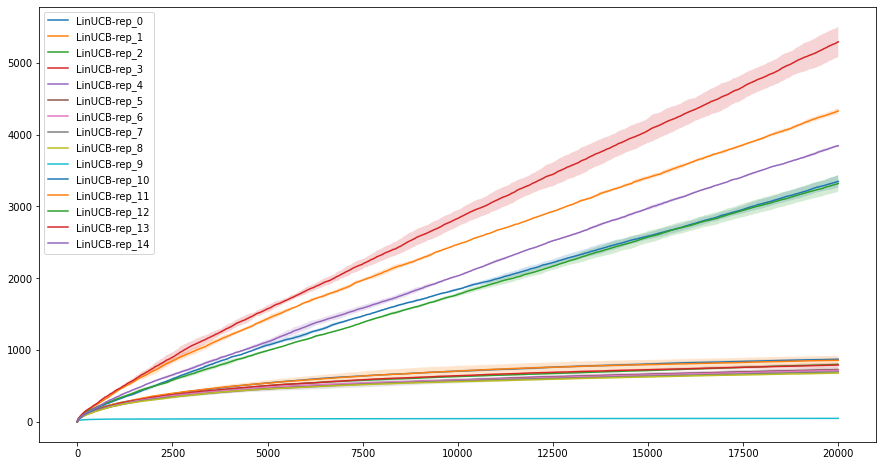

In [11]:
plt.figure(figsize=(15,8))
for k,v in results.items():
    plt.plot(np.arange(T), v['regret'], label=k)
    plt.fill_between(np.arange(T), v['regret'] - 2*v['std'], v['regret'] + 2*v['std'], alpha=0.2)
plt.legend()

In [12]:
regrets = np.zeros((NRUNS,T))
M = len(rep_list)
for r in range(NRUNS):
    print("="*30)
    print(f"run {r}")
    print("-"*30)
    algo = LEADER(env, representations=rep_list, reg_val=1, noise_std=NOISE, 
                  features_bounds=[np.linalg.norm(rep_list[j].features,2, axis=-1).max() for j in range(M)], 
                  param_bounds=[np.linalg.norm(param_list[j],2) for j in range(M)],
                  check_elim_condition_every=50
    )
    output = algo.run(T)
    regrets[r] = output['regret']

mr = np.mean(regrets, axis=0)
vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
results['LEADER'] = {'regret': mr, 'std': vr}

run 0
------------------------------
t(3350): elim 13 since 0.6423567636443063 > 0.6399995305275116
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
t(4700): elim 11 since 0.5339352369255932 > 0.5333445866633144
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]
t(4950): elim 12 since 0.5218819091736141 > 0.5215552884374581
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14]
t(5150): elim 14 since 0.5131967841401429 > 0.5121569942266546
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
t(5450): elim 10 since 0.498575362918046 > 0.4970873470553989
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
run 1
------------------------------
t(3200): elim 13 since 0.663916497122209 > 0.6568125002805678
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
t(4350): elim 11 since 0.5555088595060552 > 0.5551541716564432
new active set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]
t(4950): elim 14 since 0.5206237478529513 > 0.5197975028296564
new active set: [0, 1, 2, 3

In [ ]:
regrets = np.zeros((NRUNS,T))
M = len(rep_list)
for r in range(NRUNS):
    algo = LEADERSelect(env, representations=rep_list, reg_val=1, noise_std=NOISE, 
                  features_bounds=[np.linalg.norm(rep_list[j].features,2, axis=-1).max() for j in range(M)], 
                  param_bounds=[np.linalg.norm(param_list[j],2) for j in range(M)],
                  recompute_every=50, normalize=True
    )
    output = algo.run(T)
    regrets[r] = output['regret']

mr = np.mean(regrets, axis=0)
vr = np.std(regrets, axis=0) / np.sqrt(NRUNS)
results['LEADERSelect'] = {'regret': mr, 'std': vr}

In [ ]:
plt.figure(figsize=(15,8))
for k,v in results.items():
    if k == 'LEADER':
        plt.plot(np.arange(T), v['regret'], '--', label=k)
    elif k == 'LEADERSelect':
        plt.plot(np.arange(T), v['regret'], ':', label=k)
    else:
        plt.plot(np.arange(T), v['regret'], label=k)
    plt.fill_between(np.arange(T), v['regret'] - 2*v['std'], v['regret'] + 2*v['std'], alpha=0.2)
plt.legend()